In [2]:
# Empirical Price Analysis
import csv
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np

def load_eth_price_data():
    with open("../data/weth_usdc_005_tier_trades.csv","r") as infile:
        data = pd.read_csv(infile)

    with open("../data/weth_usdc_005_tier_trades2.csv","r") as infile:
        data2 = pd.read_csv(infile)

    data3 = pd.concat([data,data2]).drop_duplicates()
    data3["WETH"]=data3["amount1"].apply(lambda x: int(x) / 1e18)
    data3["USDC"]=data3["amount0"].apply(lambda x: int(x)/1e6)
    data3["price_implied"] = data3["price_implied"]/1e18
    data3["price_actual"] = data3["price_actual"]/1e18
    data3["price_impact"]=abs(data3["price_implied"]-data3["price_actual"])/data3["price_implied"]
    data3["evt_block_time"] = pd.to_datetime(data3['evt_block_time'], utc=True)
    data3["hourly_blocktime"] = data3["evt_block_time"].dt.floor("H")
    data3["daily_blocktime"] = data3["evt_block_time"].dt.floor("D")
    data3['unix_timestamp'] = data3['evt_block_time'].astype(int) // 10**9
    data3.sort_values(by="unix_timestamp", axis=0, ascending=True, inplace=True, kind='quicksort', na_position='last')
    data3["hourly_timestamp"] = data3["hourly_blocktime"].astype(int) // 10**9
    data3["daily_timestamp"] = data3["daily_blocktime"].astype(int) // 10**9
    return(data3)

    Bin_Left_Edge  Bin_Reft_Edge  Count
0        0.003270       0.006504      7
1        0.006504       0.009738     10
2        0.009738       0.012972     23
3        0.012972       0.016206     27
4        0.016206       0.019440     21
..            ...            ...    ...
95       0.310499       0.313733      0
96       0.313733       0.316967      0
97       0.316967       0.320200      0
98       0.320200       0.323434      0
99       0.323434       0.326668      1

[100 rows x 3 columns] 355


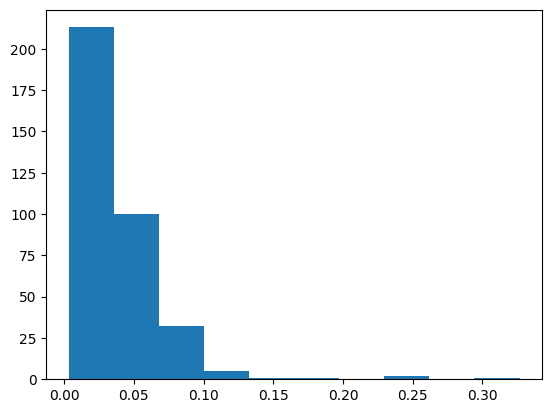

    Bin_Left_Edge  Bin_Reft_Edge  Count
0        0.000000       0.001246    911
1        0.001246       0.002492   1759
2        0.002492       0.003738   1421
3        0.003738       0.004984   1000
4        0.004984       0.006231    696
..            ...            ...    ...
95       0.118381       0.119628      0
96       0.119628       0.120874      0
97       0.120874       0.122120      0
98       0.122120       0.123366      0
99       0.123366       0.124612      1

[100 rows x 3 columns] 8340


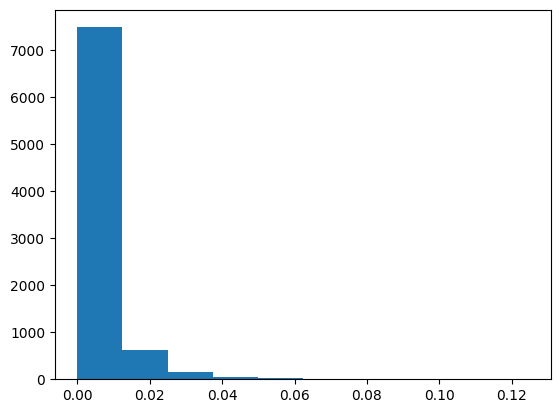

In [3]:
df = load_eth_price_data()

daily_price_data = df.groupby("daily_timestamp").agg({"price_actual": ["min","max","mean",
    ("first", lambda x: x.iloc[0]),("last", lambda x: x.iloc[-1])]})
daily_price_data["drops"]=(daily_price_data["price_actual"]["max"]-daily_price_data["price_actual"]["min"])/daily_price_data["price_actual"]["first"]
daily_price_data["drops_bin"] = (daily_price_data["drops"]*1000).astype(int)/1000

counts,bin_edges = np.histogram(daily_price_data["drops"],bins=100)
hist_daily_df = pd.DataFrame({"Bin_Left_Edge":bin_edges[:-1],"Bin_Reft_Edge":bin_edges[1:],"Count":counts})

hourly_price_data = df.groupby("hourly_timestamp").agg({"price_actual": ["min","max","mean",
    ("first", lambda x: x.iloc[0]),("last", lambda x: x.iloc[-1])]})
hourly_price_data["drops"]=(hourly_price_data["price_actual"]["max"]-hourly_price_data["price_actual"]["min"])/hourly_price_data["price_actual"]["first"]
hourly_price_data["drops_bin"] = (hourly_price_data["drops"]*1000).astype(int)/1000

counts,bin_edges = np.histogram(hourly_price_data["drops"],bins=100)
hist_hourly_df = pd.DataFrame({"Bin_Left_Edge":bin_edges[:-1],"Bin_Reft_Edge":bin_edges[1:],"Count":counts})

print(hist_daily_df,hist_daily_df["Count"].sum())
fig = px.scatter(x=daily_price_data.index, y=daily_price_data["drops_bin"], title="Daily Price Range")
fig.show()
plt.hist(daily_price_data["drops"],bins=10)
plt.show()

print(hist_hourly_df,hist_hourly_df["Count"].sum())
plt.hist(hourly_price_data["drops"],bins=10)
plt.show()
fig = px.scatter(x=hourly_price_data.index, y=hourly_price_data["drops_bin"], title="Hourly Price Range")
fig.show()
